In [46]:
pip install opencv-python-headless tensorflow pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [47]:
# Import necessary libraries
import os
import cv2
import numpy as np
import json
import math
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [48]:
# Define paths
video_dir = 'visualize'
model_path = 'checkpoints/model_epoch_05_val_accuracy_0.96.keras'
frame_output_dir = 'extracted_frames'
os.makedirs(frame_output_dir, exist_ok=True)

In [49]:
# Load the model
model = load_model(model_path)

In [50]:
# Function to extract one frame per second from a video
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frames = []
    count = 0
    while cap.isOpened():
        frame_id = cap.get(cv2.CAP_PROP_POS_FRAMES)
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id % math.floor(frame_rate) == 0:
            frames.append(frame)
        count += 1
    cap.release()
    return frames

In [51]:
# Function to detect and crop face from a frame using MTCNN
def crop_face(frame, detector):
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(image_rgb)
    if len(results) == 0:
        return None
    result = results[0]
    bounding_box = result['box']
    margin_x = bounding_box[2] * 0.3  # 30% as the margin
    margin_y = bounding_box[3] * 0.3  # 30% as the margin
    x1 = max(0, int(bounding_box[0] - margin_x))
    x2 = min(frame.shape[1], int(bounding_box[0] + bounding_box[2] + margin_x))
    y1 = max(0, int(bounding_box[1] - margin_y))
    y2 = min(frame.shape[0], int(bounding_box[1] + bounding_box[3] + margin_y))
    face = frame[y1:y2, x1:x2]
    face = cv2.resize(face, (224, 224))
    return face

# Initialize the face detector
detector = MTCNN()

In [59]:
# Process videos
results = []
total_real_count = 0
total_fake_count = 0

for actual_status in ['real', 'fake']:
    category_dir = os.path.join(video_dir, actual_status)
    output_category_dir = os.path.join(frame_output_dir, actual_status)
    os.makedirs(output_category_dir, exist_ok=True)
    for video_file in os.listdir(category_dir):
        video_path = os.path.join(category_dir, video_file)
        video_output_dir = os.path.join(output_category_dir, video_file.split('.')[0])
        os.makedirs(video_output_dir, exist_ok=True)
        print(f"Processing video: {video_path}")
        frames = extract_frames(video_path)
        real_count = 0
        fake_count = 0
        for i, frame in enumerate(frames):
            face = crop_face(frame, detector)
            if face is not None:
                face_path = os.path.join(video_output_dir, f"frame_{i:03d}.png")
                cv2.imwrite(face_path, cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
                
                face_array = img_to_array(face)
                face_array = np.expand_dims(face_array, axis=0)
                face_array = preprocess_input(face_array)
                prediction = model.predict(face_array)
                label = 'fake' if prediction[0][0] > 0.5 else 'real'
                if label == 'fake':
                    fake_count += 1
                else:
                    real_count += 1
                results.append((video_file, i, label, actual_status))
            else:
                print(f"No face detected in frame {i} of {video_file}")
        total_real_count += real_count
        total_fake_count += fake_count
        print(f'Video: {video_file}, Real Faces: {real_count}, Fake Faces: {fake_count}')

print(f'Total Real Faces: {total_real_count}, Total Fake Faces: {total_fake_count}')

Processing video: visualize\real\desktop.ini
Video: desktop.ini, Real Faces: 0, Fake Faces: 0
Processing video: visualize\fake\Fake_Video Face Swap.mov
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [60]:
# Save results
results_df = pd.DataFrame(results, columns=['Video', 'Frame', 'Prediction', 'Actual'])
results_df.to_csv(os.path.join(frame_output_dir, 'predictions.csv'), index=False)

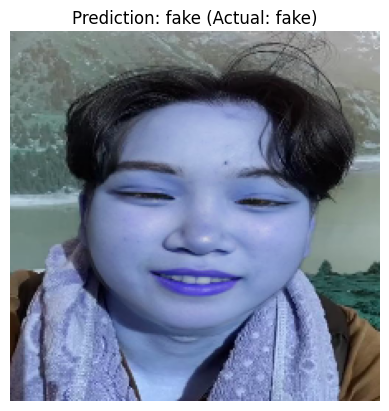

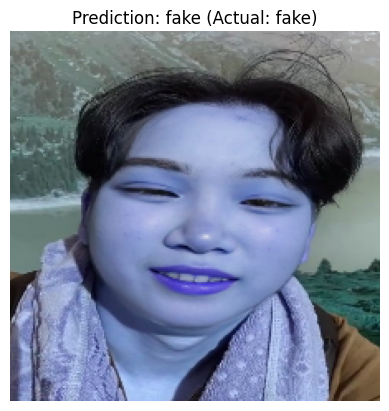

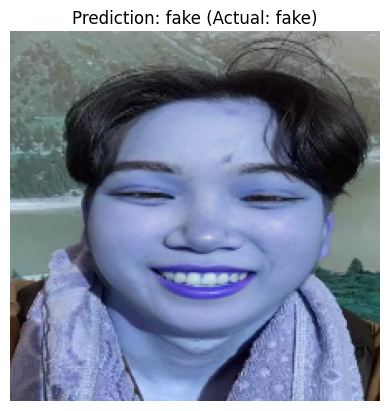

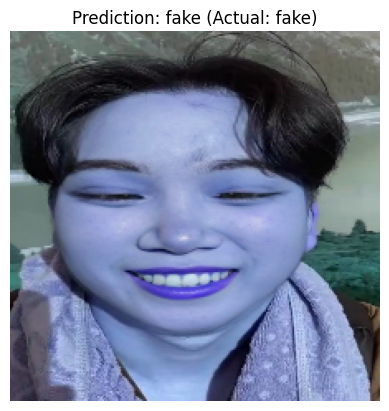

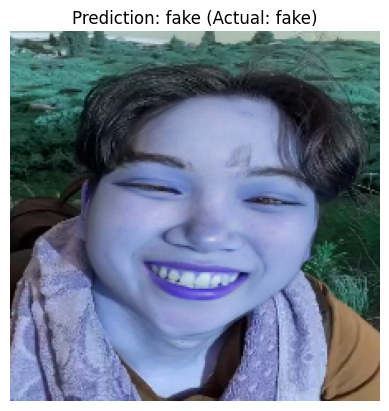

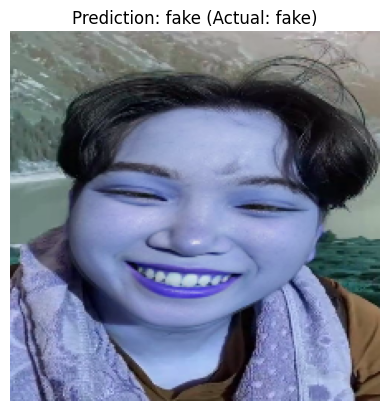

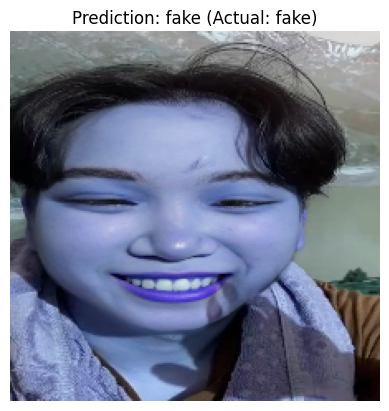

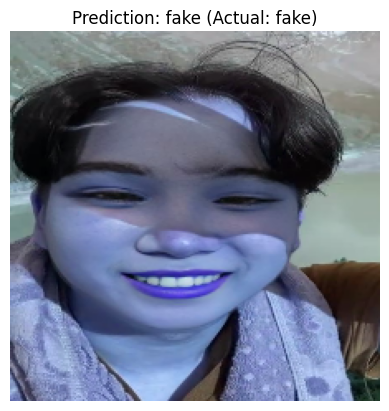

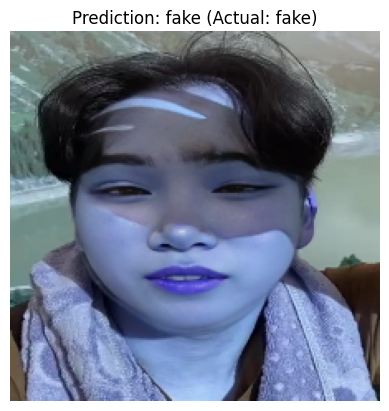

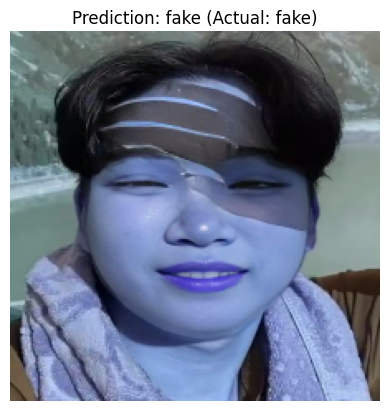

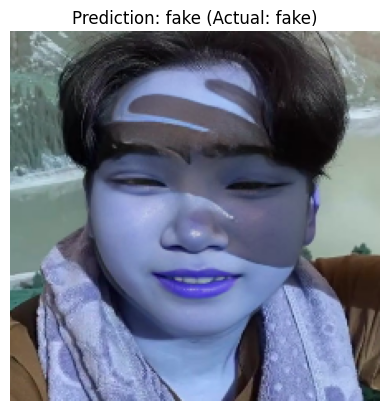

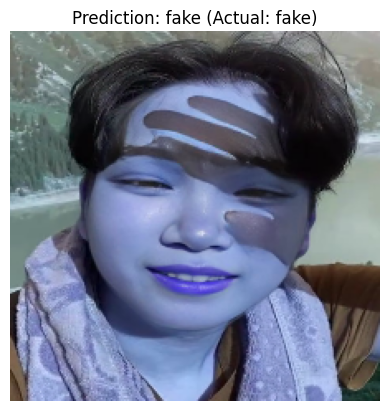

In [61]:
# Plot predictions for all images
for video_file, frame_index, label, actual_status in results:
    video_output_dir = os.path.join(frame_output_dir, actual_status, video_file.split('.')[0])
    face_path = os.path.join(video_output_dir, f"frame_{frame_index:03d}.png")
    if os.path.exists(face_path):
        face = cv2.imread(face_path)
        plt.figure()
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.title(f'Prediction: {label} (Actual: {actual_status})')
        plt.axis('off')
        plt.show()
    else:
        print(f"Frame {frame_index} from video {video_file} does not exist")